In [0]:
#@title imports
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tempfile
import io


# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving googleplaystore.csv to googleplaystore.csv
User uploaded file "googleplaystore.csv" with length 1360155 bytes


In [0]:
COLUMNS = ["app", "category", "rating", "reviews", "size", "installs", "type", 
           "price", "content", "genres", "last_update", "current_version", "android_version"]
census_df = pd.read_csv(io.StringIO(uploaded['googleplaystore.csv'].decode('utf-8')), names=COLUMNS, skipinitialspace=True)
census_df = census_df.iloc[1:]
census_df.head(1)

,app,category,rating,reviews,size,installs,type,price,content,genres,last_update,current_version,android_version
1,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up


In [0]:

census_df['rating'] = pd.to_numeric(census_df['rating'], errors='coerce')
census_df['reviews'] = pd.to_numeric(census_df['reviews'], errors='coerce')
mean = census_df['rating'].mean()
census_df['rating'].fillna(mean, inplace=True)
mean = census_df['reviews'].mean()
census_df['reviews'].fillna(mean, inplace=True)
census_df = census_df.replace(np.nan, '', regex=True)

In [0]:
##this drops a bad row of the data that causes issues
# census_df = census_df.drop([10473, 10473], axis=0)

census_df = census_df.drop([10473, 10473], axis=0)
census_df = census_df.drop([9149, 9149], axis=0)

In [0]:
#@title linear_scale, log_scale, and clip
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged.
  series = series.clip(clip_to_min, clip_to_max)
  return series.apply(lambda x: x)

In [0]:
def prepare_type_help(x):
  if(x == "Free"):
    return 0
  elif(x == "Paid"):
    return 1
  else:
    return 0

def prepare_type(series):
  return series.apply(lambda x: prepare_type_help(x))

In [0]:
def prepare_price_help(price):
  temp = price.replace('$', '')
  if(price == 'Everyone'):
    return 0
  else:
    return int(float(temp))
def prepare_price(series):
  return series.apply(lambda x: prepare_price_help(x))

In [0]:
#@title prepare_size
def prepare_size_help(size):
  size = size.replace(',', '')
  end = size[-1]
  if(end == "M"):
    return int(float(size[:-1]) * 1000000)
  elif(end == "k"):
    return int(float(size[:-1]) * 1000)
  elif(end == "+"):
    return int(float(size[:-1]))
  else:
    return 0
  
def replace_with_mean(x, mean):
  if(x == 0):
    return mean
  else:
    return x
  
def prepare_size(series):
  cop = series.apply(lambda x: prepare_size_help(x))
  mean = cop.mean()
  return cop.apply(lambda x: replace_with_mean(x, mean))
  

In [0]:

NUMERICAL_FEATURES = ["rating", "reviews", "size", "type", "price"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "currmaent_version", "android_version"]

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain the data.
  Returns:
    A new DataFrame that contains the features to be used for the model.
   
  """
  
  processed_features = dataframe.copy()
  
  # TODO: FIX
#   possible_values = list(np.unique(processed_features['installs']))

  possible_values = list(np.array(['0+', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+', 
                                   '5,000+',  '10,000+', '50,000+', '100,000+', '500,000+', '1,000,000+', 
                                   '5,000,000+', '10,000,000+', '50,000,000+', '100,000,000+', 
                                   '500,000,000+', '1,000,000,000+']))
  
  processed_features['installs'] = np.array([possible_values.index(v) for v in processed_features['installs']])
  
  processed_features["rating"] = linear_scale(log_scale(processed_features["rating"]))
  processed_features["reviews"] = linear_scale(log_scale(processed_features["reviews"]))
  processed_features["size"] = linear_scale(log_scale(prepare_size(processed_features["size"])))
  processed_features["price"] = log_scale(log_scale(prepare_price(processed_features["price"])))
  processed_features["type"] = prepare_type(processed_features["type"])

  
  return processed_features

In [0]:
#@title draw_histograms
copy = prepare_features(census_df)

clip_min = -np.inf
clip_max = np.inf

def draw_histograms(dataframe, feature_name,
                    clip_min = -np.inf, clip_max = np.inf):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = dataframe[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(
      clip(dataframe[feature_name], clip_min, clip_max))
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(dataframe[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)

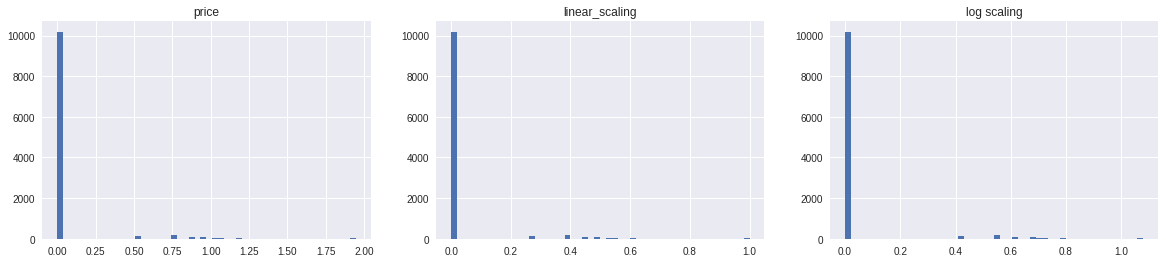

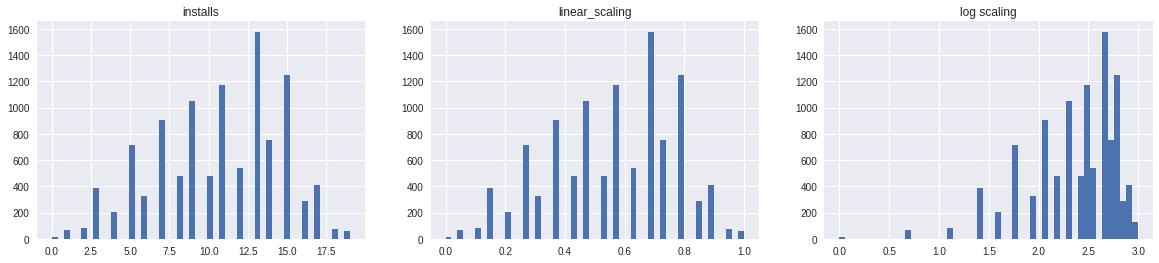

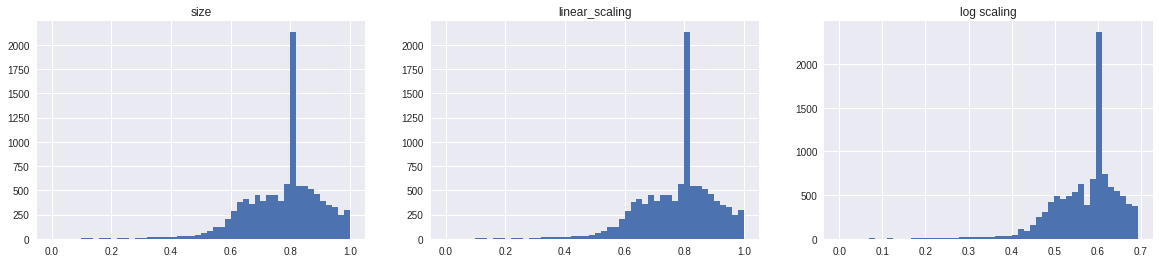

In [0]:
draw_histograms(copy, 'price')
draw_histograms(copy, 'installs')
draw_histograms(copy, 'size')

In [0]:
census_df = census_df.reindex(np.random.permutation(census_df.index))
training_examples = prepare_features(census_df.head(9000))
validation_examples = prepare_features(census_df.tail(659))

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [q for q in quantiles]

In [0]:


NUMERICAL_FEATURES = ["rating", "reviews", "size", "price", "type"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "current_version", "android_version"]


def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """

  rating = tf.contrib.layers.real_valued_column("rating")
  reviews = tf.contrib.layers.real_valued_column("reviews")
  size = tf.contrib.layers.real_valued_column("size")
  price = tf.contrib.layers.real_valued_column("price")
  type_d = tf.contrib.layers.real_valued_column("type")
  type_d_buckets = tf.contrib.layers.bucketized_column(type_d, [0.5])
  
  category = tf.contrib.layers.sparse_column_with_hash_bucket( "category", hash_bucket_size=50)
  content = tf.contrib.layers.sparse_column_with_hash_bucket( "content", hash_bucket_size=50)
#   genres = tf.contrib.layers.sparse_column_with_hash_bucket( "genres", hash_bucket_size=50)
#   last_update = tf.contrib.layers.sparse_column_with_hash_bucket( "last_update", hash_bucket_size=50)
#   current_version = tf.contrib.layers.sparse_column_with_hash_bucket( "current_version", hash_bucket_size=50)
  android_version = tf.contrib.layers.sparse_column_with_hash_bucket( "android_version", hash_bucket_size=50)
  
  
  
  feature_columns=[rating, reviews, size, type_d_buckets, price,  content, android_version, category]
#   , content, android_version, category

 
  return feature_columns

In [0]:
#@title input_fn
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
NUMERICAL_FEATURES = ["rating", "reviews", "size", "price", "type"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "current_version", "android_version"]
LABEL = "installs"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

In [0]:
#@title compute_loss
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

In [0]:
#@title plot_learning_curve
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

In [0]:
#@title calibration_plot
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

In [0]:
#@title define_linear_regression_model
def define_linear_regression_model(learning_rate, l1_regularization_strength, 
                                  l2_regularization_strength):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.FtrlOptimizer(
      learning_rate=learning_rate,
      l1_regularization_strength=l1_regularization_strength,
      l2_regularization_strength=l2_regularization_strength)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

In [0]:
#@title train_model
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validatin_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the training loss
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    training_loss = compute_loss(predictions, training_labels)
    training_losses.append(training_loss) 
    
    # Use the predict method to compute the validation loss
    predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    validation_loss = compute_loss(predictions, validation_labels)
    validation_losses.append(validation_loss) 
    print "  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss)
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % training_loss) 
  print("Final Loss (RMSE) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and a calibration
  # plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot on Validation Data")
  calibration_plot(predictions, validation_labels)
   
  return linear_regressor

In [0]:
NUMERICAL_FEATURES = ["rating", "reviews", "size", "price", "type"]
CATEGORICAL_FEATURES = ["app", "category", "content", "genres", "last_update", "current_version", "android_version"]

FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES

LABEL = "installs"

Training model...
  Training loss, Validation loss after period 00 : 1.210, 1.177
  Training loss, Validation loss after period 01 : 1.006, 0.985
  Training loss, Validation loss after period 02 : 0.978, 0.946
  Training loss, Validation loss after period 03 : 0.971, 0.932
  Training loss, Validation loss after period 04 : 0.965, 0.929
  Training loss, Validation loss after period 05 : 0.963, 0.928
  Training loss, Validation loss after period 06 : 0.961, 0.924
  Training loss, Validation loss after period 07 : 0.960, 0.924
  Training loss, Validation loss after period 08 : 0.960, 0.924
  Training loss, Validation loss after period 09 : 0.959, 0.924
Final Loss (RMSE) on the training data: 0.959
Final Loss (RMSE) on the validation data: 0.924


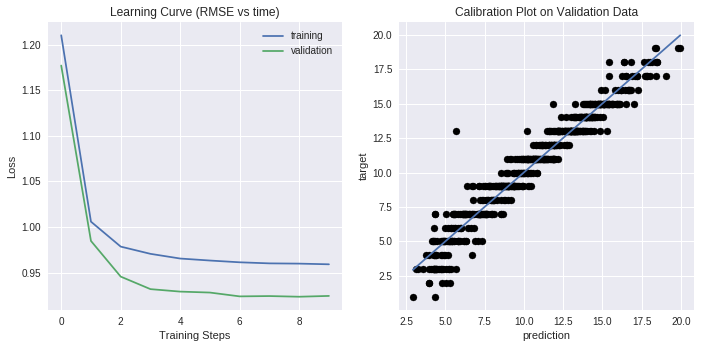

In [0]:
LEARNING_RATE = 0.1
STEPS = 50000
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE, 
                                               l1_regularization_strength=140.0, 
                                                 l2_regularization_strength=0.0)
linear_regressor = train_model(
    linear_regressor, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], 
    batch_size=BATCH_SIZE, 
    steps=STEPS)